In [190]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)
from scipy.stats import gaussian_kde
from scipy.stats import gamma, lognorm
import pandas as pd

from mat_models import MR, mn_sigma_vmap as mn_sigma
from utils_node import init_params, NODE_model
from utils import train_jp, eval_Cauchy_vmap
from utils_diffusion import *

In [2]:
# Define the loss function for when training all params
@jit
def loss_sig_all(params, lamb_sigma):
    model   = NODE_model(params)
    lambx   = lamb_sigma[:,0]
    lamby   = lamb_sigma[:,1]
    sigmax  = lamb_sigma[:,2]
    sigmay  = lamb_sigma[:,3]
    sigx,sigy = eval_Cauchy_vmap(lambx,lamby,model)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

[[(-1.0, 30.0)], [(-1.0, 30.0)], [(-1.0, 30.0)]]

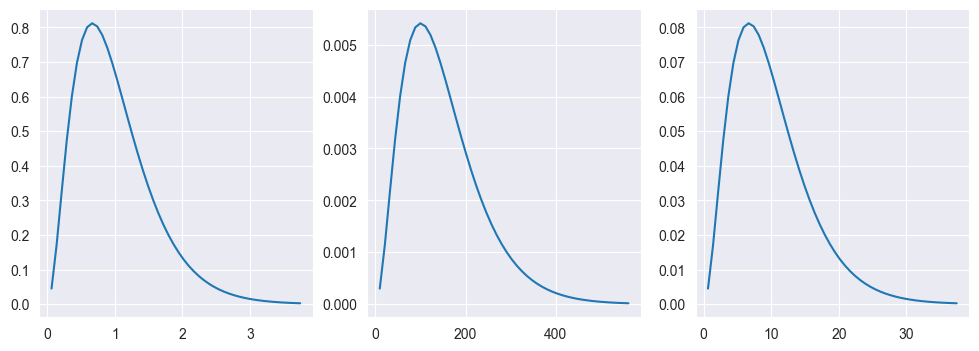

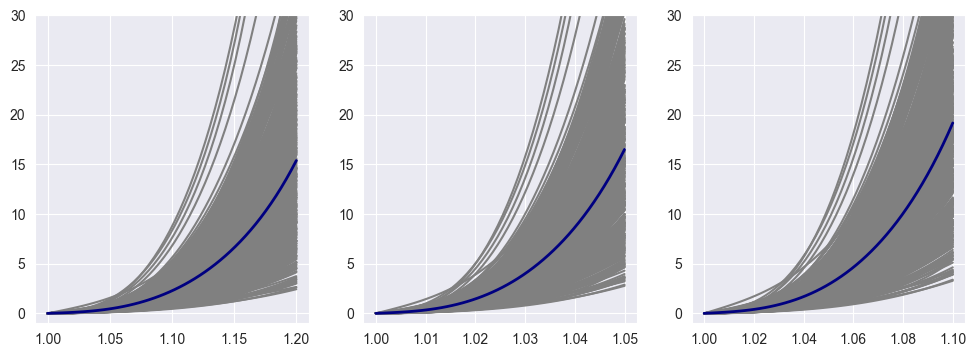

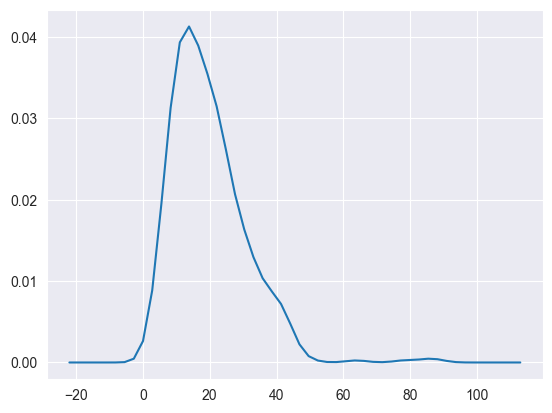

In [3]:
# Generate training data from May-Newmann model
MN_params  = [1.0,         150,         10] # baseline params
J = 500 # 10 different samples 
fig, ax = plt.subplots(1,3,figsize=(12,4))
MN_params_s = np.zeros((J,len(MN_params)))
theta = 1.0
tikzdata = []
for j in range(len(MN_params)):
    p = MN_params[j]
    a = 3.0
    scale = p/3
    x = np.linspace(gamma.ppf(0.001, a, scale=scale), 
                    gamma.ppf(0.999, a, scale=scale))
    y = gamma.pdf(x, a=a, scale=scale)
    ax[j].plot(x,y)
    tikzdata.append([x,y])
    for i in range(J):
        MN_params_s[i,j] = gamma.rvs(a, scale=scale)

tikzdata = np.array(tikzdata).reshape(6,-1)
np.savetxt('tikz/fig_MoG_data/param_dist.csv', tikzdata.T, header='x1 y1 x2 y2 x3 y3', comments='')
np.savetxt('tikz/fig_analytical_wide_data/param_dist.csv', tikzdata.T, header='x1 y1 x2 y2 x3 y3', comments='')

# Given thse parameters, generate bunch of curves for different tests
# and plot to see: 3 different biaxial deformations going from strip biax, to off, to equi-biaxial 
lam_ls = np.linspace(1,1.2,50)
lam_vec = np.zeros((3*50,2))
for i in range(3):
    alpha = i/4
    lam_vec[i*50:(i+1)*50,0] = 1+alpha*(lam_ls-1)
    lam_vec[i*50:(i+1)*50,1] = 1+(1-alpha)*(lam_ls-1)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
# all 10 samples
sigma_gt_s = []
header = 'x'
for j in range(J):
    sigma_gt_si = mn_sigma(lam_vec, MN_params_s[j])
    sigma_gt_s.append(sigma_gt_si)

    axs[0].plot(lam_vec[:50,1],         sigma_gt_si[0][:50]       ,color='grey')
    axs[1].plot(lam_vec[50:2*50,0],     sigma_gt_si[0][50:2*50]   ,color='grey')
    axs[2].plot(lam_vec[2*50:3*50,0],   sigma_gt_si[0][2*50:3*50] ,color='grey')
    header = header + ' y' + str(j)
tikzdata = np.vstack([lam_vec[2*50:3*50,0],np.array(sigma_gt_s)[:,0,2*50:3*50]]).T
np.savetxt('tikz/fig_MoG_data/data_sgmx_equi.csv', tikzdata, header = header, comments = '')
np.savetxt('tikz/fig_analytical_wide_data/data_sgmx_equi.csv', tikzdata, header = header, comments = '')
stat = tikzdata[-1,1:]
kernel = gaussian_kde(stat)
xmin = np.min(stat)
xmax = np.max(stat)
r = xmax-xmin
x = np.linspace(xmin - 0.3*r, xmax + 0.3*r)
y = kernel(x)
np.savetxt('tikz/fig_MoG_data/data_sgmx_at_1.1_equi.csv', np.stack([x,y]).T, header='x y', comments='')
np.savetxt('tikz/fig_analytical_wide_data/data_sgmx_at_1.1_equi.csv', np.stack([x,y]).T, header='x y', comments='')
fig, ax = plt.subplots()
ax.plot(x,y)

# mean response
sigma_gt_m = mn_sigma(lam_vec, MN_params)
axs[0].plot(lam_vec[:50,1],         sigma_gt_m[0][:50]      ,color='navy',linewidth=2)
axs[1].plot(lam_vec[50:2*50,0],     sigma_gt_m[0][50:2*50]  ,color='navy',linewidth=2)
axs[2].plot(lam_vec[2*50:3*50,0],   sigma_gt_m[0][2*50:3*50],color='navy',linewidth=2)

[ax.set(ylim=[-1,30]) for ax in axs]


In [4]:
# Restructure the stress-stretch data a bit
lamx_all,   lamy_all    = np.array([lam_vec]*J).reshape([-1,2]).T     # Repeat the same lmx & lmy values J times
sigmax_all, sigmay_all  = np.array(sigma_gt_s).transpose([1,0,2]).reshape([2,-1])
lamb_sigma = np.vstack([lamx_all,lamy_all,sigmax_all,sigmay_all]).transpose()

## just the mean response
sigmax_r = lamb_sigma[:,2].reshape((J,150))
sigma_x_m = np.mean(sigmax_r,axis=0)
sigmay_r = lamb_sigma[:,3].reshape((J,150))
sigma_y_m = np.mean(sigmay_r,axis=0)
lamb_sigma_m = np.vstack([lam_vec[:,0],lam_vec[:,1],sigma_x_m,sigma_y_m]).transpose()

In [40]:
# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, 5, 5]
sample_layers = [5,1]
params_all = init_params(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params_all)

# Train
params_all, train_loss, val_loss = train_jp(loss_sig_all, lamb_sigma_m, get_params, opt_update, opt_state, key, nIter = 200000, print_freq=10000)
with open('params/fig_MoG/MN_cparams.npy', 'wb') as f:
    pickle.dump(params_all, f)

it 10000, train loss = 9.107663e-01
it 20000, train loss = 3.882872e-01
it 30000, train loss = 3.034426e-01
it 40000, train loss = 2.662407e-01
it 50000, train loss = 2.464430e-01
it 60000, train loss = 2.342891e-01
it 70000, train loss = 2.226912e-01
it 80000, train loss = 2.156210e-01
it 90000, train loss = 2.188029e-01
it 100000, train loss = 2.055407e-01
it 110000, train loss = 2.017793e-01
it 120000, train loss = 3.544031e-01
it 130000, train loss = 1.958508e-01
it 140000, train loss = 1.934566e-01
it 150000, train loss = 1.913785e-01
it 160000, train loss = 1.894834e-01
it 170000, train loss = 1.878015e-01
it 180000, train loss = 1.862845e-01
it 190000, train loss = 1.849118e-01
it 200000, train loss = 1.836492e-01


In [5]:
with open('params/fig_MoG/MN_cparams.npy', 'rb') as f:
    params_all = pickle.load(f)

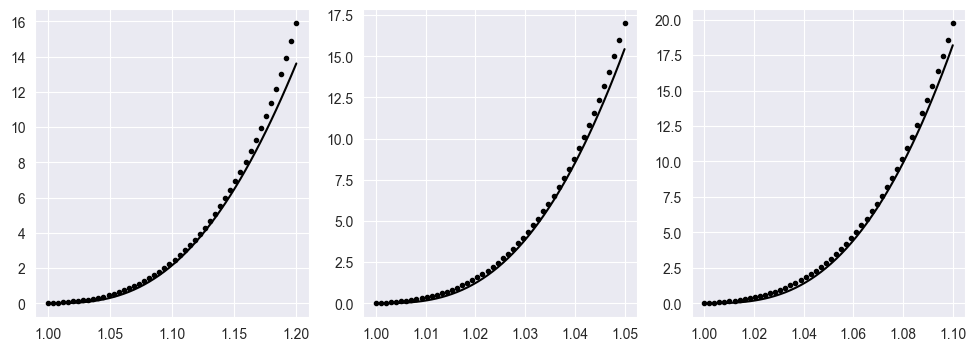

In [6]:
mymodel = NODE_model(params_all)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

axs[0].plot(lam_vec[:50,1],         lamb_sigma_m[:50,2],        'k.')
axs[1].plot(lam_vec[50:2*50,0],     lamb_sigma_m[50:2*50,2],    'k.')
axs[2].plot(lam_vec[2*50:3*50,0],   lamb_sigma_m[2*50:3*50,2],  'k.')

sigx,sigy = eval_Cauchy_vmap(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel)
axs[0].plot(lam_vec[:50,1],         sigx[:50],      'k')
axs[1].plot(lam_vec[50:2*50,0],     sigx[50:2*50],  'k')
axs[2].plot(lam_vec[2*50:3*50,0],   sigx[2*50:3*50],'k')

In [7]:
# fit individually 
key = random.PRNGKey(0)
NODE_weights, Psi1_bias, Psi2_bias = params_all
params_I1, params_I2 = NODE_weights
params_I1c,params_I1s_m = params_I1
params_I2c,params_I2s_m = params_I2

def loss_sample(sample_params, X): #This keeps the common params constant and varies sample_params
    params_I1 = (params_I1c, sample_params[0])
    params_I2 = (params_I2c, sample_params[1])
    NODE_weights = (params_I1, params_I2)
    params = (NODE_weights, sample_params[2], sample_params[3])
    return loss_sig_all(params, X)

mean_sample_params = (params_I1s_m,params_I2s_m, Psi1_bias, Psi2_bias, alpha)

Sample_params = []
p = 10
start = 450
for j in range(start,J):
    sigx = sigma_gt_s[j][0]
    sigy = sigma_gt_s[j][1]
    lamb_sigma_j = np.vstack([lam_vec[:,0],lam_vec[:,1],sigx,sigy]).transpose()
    opt_init, opt_update, get_params = optimizers.adam(5e-4)
    opt_state = opt_init(mean_sample_params)

    print(j)
    sample_params, train_loss, val_loss = train_jp(loss_sample, lamb_sigma_j, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=5000)
    Sample_params.append(sample_params)

    if j%50==0 and j>start:
        with open('params/fig_MoG/MN_sparams_part_' + str(p) + '.npy', 'wb') as f:
            pickle.dump(Sample_params, f)
        Sample_params = []
        p+= 1

450
it 5000, train loss = 1.148469e+00
it 10000, train loss = 1.148469e+00
451
it 5000, train loss = 3.629392e-01
it 10000, train loss = 3.629392e-01
452
it 5000, train loss = 6.321462e-01
it 10000, train loss = 6.321462e-01
453
it 5000, train loss = 2.621699e-02
it 10000, train loss = 2.621699e-02
454
it 5000, train loss = 1.523830e-01
it 10000, train loss = 1.282242e-01
455
it 5000, train loss = 1.845343e-01
it 10000, train loss = 1.845343e-01
456
it 5000, train loss = 2.649561e-01
it 10000, train loss = 2.649561e-01
457
it 5000, train loss = 6.303597e+00
it 10000, train loss = 6.303597e+00
458
it 5000, train loss = 8.360303e-01
it 10000, train loss = 8.360303e-01
459
it 5000, train loss = 2.323041e+00
it 10000, train loss = 2.323041e+00
460
it 5000, train loss = 1.557768e-01
it 10000, train loss = 1.557768e-01
461
it 5000, train loss = 2.798623e-01
it 10000, train loss = 2.798623e-01
462
it 5000, train loss = 1.028139e-01
it 10000, train loss = 8.750976e-02
463
it 5000, train loss =

In [68]:
Sample_params = []
for part in range(9):
    with open('params/fig_MoG/MN_sparams_part_' + str(part+1) + '.npy', 'rb') as f:
        aux = pickle.load(f)
        for a in aux:
            Sample_params.append(a)

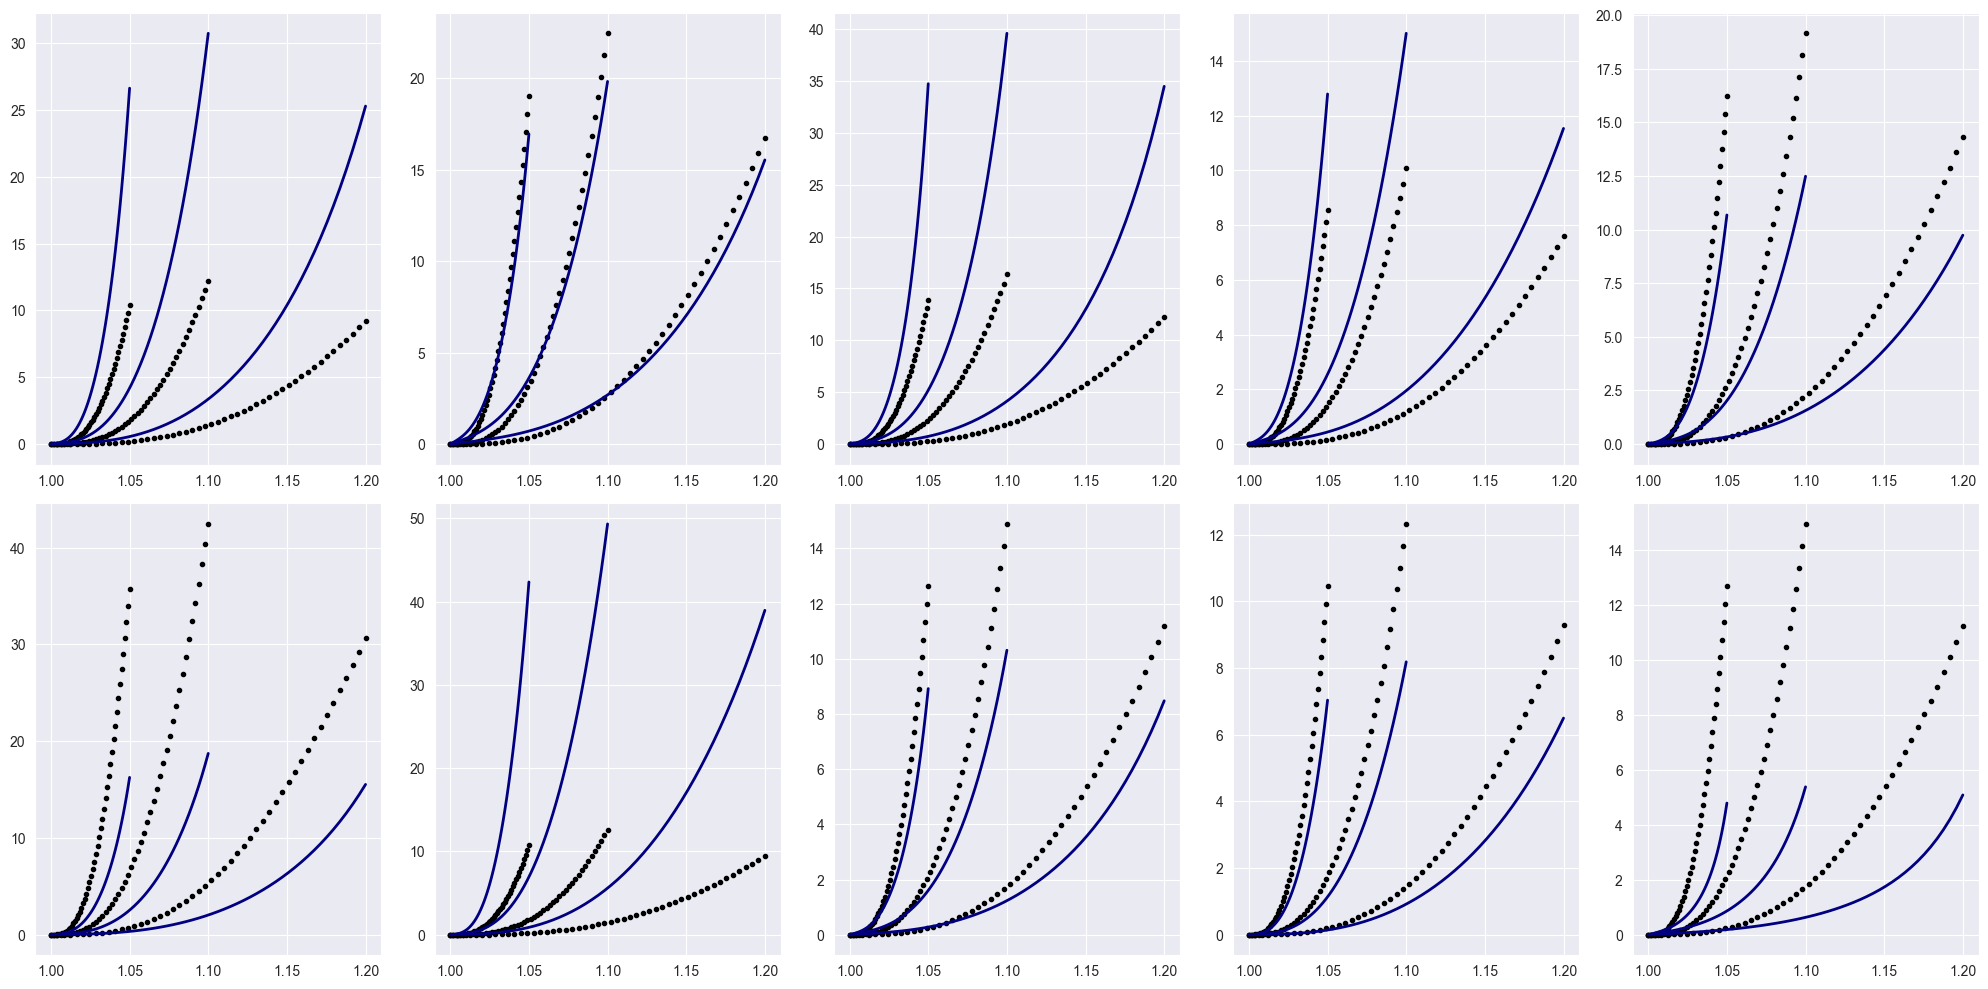

In [69]:
plt.figure(figsize = (20,10))
for i, sample_params in enumerate(Sample_params[:10]): #plot the first 10
    params_I1 = (params_I1c, sample_params[0])
    params_I2 = (params_I2c, sample_params[1])
    NODE_weights = (params_I1, params_I2)
    params = (NODE_weights, sample_params[2], sample_params[3])

    mymodel = NODE_model(params)
    sigx,sigy = eval_Cauchy_vmap(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel)
    sigx_gt = sigma_gt_s[i][0]
    sigy_gt = sigma_gt_s[i][1]

    plt.subplot(2,5,i+1)

    plt.plot(lam_vec[:50,1],        sigx[:50],      'k.',linewidth=2)
    plt.plot(lam_vec[50:2*50,0],    sigx[50:2*50],  'k.',linewidth=2)
    plt.plot(lam_vec[2*50:3*50,0],  sigx[2*50:3*50],'k.',linewidth=2)

    plt.plot(lam_vec[:50,1],        sigx_gt[:50],       color='navy',linewidth=2)
    plt.plot(lam_vec[50:2*50,0],    sigx_gt[50:2*50],   color='navy',linewidth=2)
    plt.plot(lam_vec[2*50:3*50,0],  sigx_gt[2*50:3*50], color='navy',linewidth=2)
plt.tight_layout()

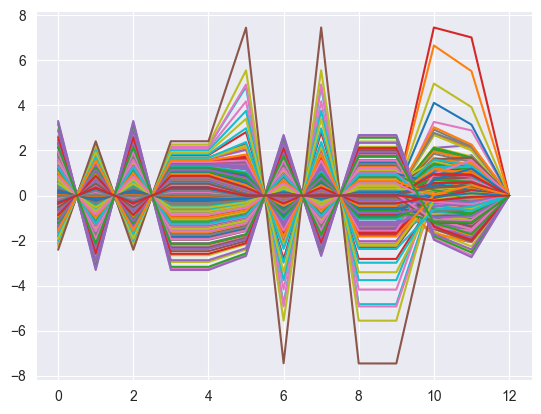

In [70]:
w_diffusion = np.array([ravel_pytree(sample_params)[0] for sample_params in Sample_params])
unravel_params = ravel_pytree(Sample_params[0])[1]

# w_diffusion_I1_I2 = w_diffusion[:,0:10] # because we are note using I1-I2
mu_x  = jnp.mean(w_diffusion,0)
std_x = jnp.std (w_diffusion,0)
w_diffusion_scaled = (w_diffusion-mu_x)/std_x

for l in w_diffusion_scaled:
    plt.plot(l)

Epoch 0 	, Loss 1.012346 


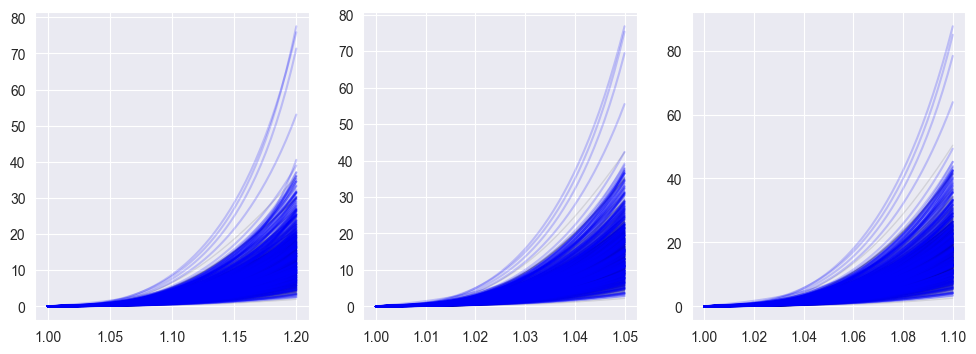

In [187]:
batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros((w_diffusion_scaled.shape[1])*batch_size).reshape((batch_size, w_diffusion_scaled.shape[1]))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model = ApproximateScore() # from diffusion_utils
params = score_model.init(rng, x, time) # from diffusion_utils
#Initialize the optimizer
optimizer = optax.adam(1.e-5)
opt_state = optimizer.init(params)
N_epochs = 500
train_size = w_diffusion.shape[0]
batch_size = 200
batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size

params = train_diffusion(w_diffusion_scaled, score_model, N_epochs, train_size, batch_size, steps_per_epoch, rng, params, optimizer, opt_state)


# Sample using the trained params
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, w_diffusion_scaled.shape[1], 1000, drift, dispersion, trained_score)


# Make stress predictions and compare
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
diff_stat_500 = []
tikzdata = [lam_vec[2*50:3*50,0]]
for l in samples:
    l_unscaled = l*std_x+mu_x 
    sample_params = unravel_params(l_unscaled)

    params_I1 = (params_I1c, sample_params[0])
    params_I2 = (params_I2c, sample_params[1])
    NODE_weights = (params_I1, params_I2)
    params = (NODE_weights, sample_params[2], sample_params[3])

    mymodel = NODE_model(params)
    sigx,sigy = eval_Cauchy_vmap(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel)

    axs[0].plot(lam_vec[:50,1],       sigx[:50],      color='k',linewidth=1,alpha=0.1)
    axs[1].plot(lam_vec[50:2*50,0],   sigx[50:2*50],  color='k',linewidth=1,alpha=0.1)
    axs[2].plot(lam_vec[2*50:3*50,0], sigx[2*50:3*50],color='k',linewidth=1,alpha=0.1)

    diff_stat_500.append(sigx[-1])
    tikzdata.append(sigx[2*50:3*50])

tikzdata = np.array(tikzdata)
np.savetxt('tikz/fig_analytical_wide_data/model_500_sgmx_equi.csv', tikzdata.T, header = header, comments = '')

data_stat = []
for j in range(J):
    axs[0].plot(lam_vec[:50,1],       sigma_gt_s[j][0][:50],      color='b',alpha=0.2)
    axs[1].plot(lam_vec[50:2*50,0],   sigma_gt_s[j][0][50:2*50],  color='b',alpha=0.2)
    axs[2].plot(lam_vec[2*50:3*50,0], sigma_gt_s[j][0][2*50:3*50],color='b',alpha=0.2)
    data_stat.append(sigma_gt_s[j][0][-1])

data_stat = np.array(data_stat)
xmin = np.min(data_stat)
xmax = np.max(data_stat)
r = xmax-xmin
x_dist = np.linspace(xmin - 0.3*r, xmax + 0.3*r, 100)
y_gt = gaussian_kde(data_stat)(x_dist)

y_diff_500 = gaussian_kde(diff_stat_500)(x_dist)
np.savetxt('tikz/fig_analytical_wide_data/model_500_sgmx_at_1.1_equi.csv', np.stack([x_dist,y_diff_500]).T, header='x y', comments='')


In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(data_stat,'b.')
ax[1].plot(diff_stat_500, 'r.')

ax[0].set(ylim=[0,np.max(data_stat)], title='Data', ylabel='$\sigma_{xx}$ at $\lambda$=1.1')
ax[1].set(ylim=[0,np.max(data_stat)], title='Diffusion')

### Try it with mixture of Gaussians

In [89]:
ws = np.array([ravel_pytree(sample_params)[0] for sample_params in Sample_params])
template, unravel_params = ravel_pytree(Sample_params[0])
template = np.array(template)

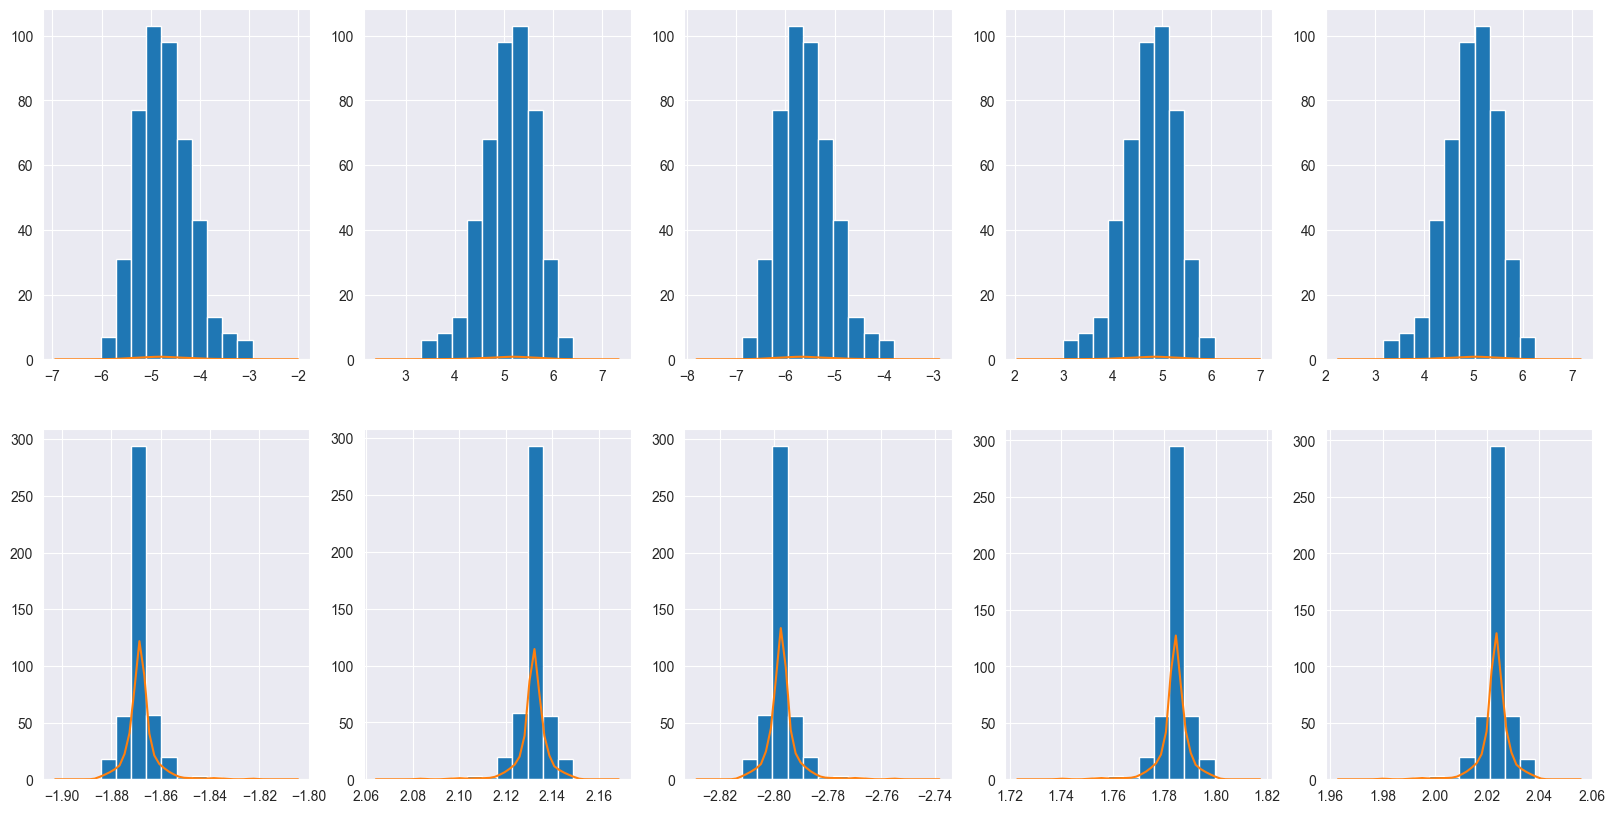

In [90]:
plt.figure(figsize = (20,10))
kernels = []
for i, w in enumerate(ws.T[:10]):
    plt.subplot(2,5,i+1)
    plt.hist(w)
    kernel = gaussian_kde(w)

    wmin = np.min(w)
    wmax = np.max(w)
    r = wmax-wmin
    w = np.linspace(wmin - 0.3*r, wmax + 0.3*r)
    y = kernel(w)

    plt.plot(w,y)
    kernels.append(kernel)

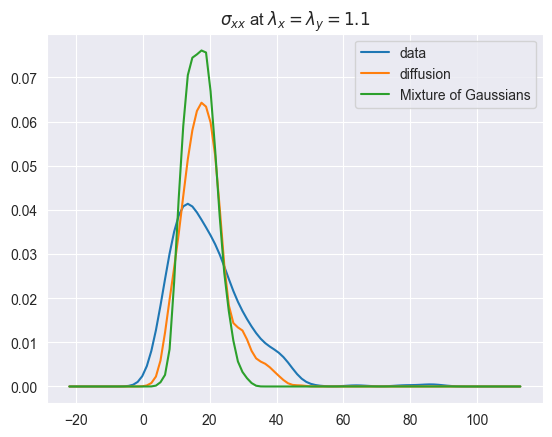

In [91]:
GM_stat = []
for i in range(J):
    for j in range(10):
        kernel = kernels[j]
        template[j] = kernel.resample(1)
    sample_params = unravel_params(template)
    
    params_I1 = (params_I1c, sample_params[0])
    params_I2 = (params_I2c, sample_params[1])
    NODE_weights = (params_I1, params_I2)
    params = (NODE_weights, sample_params[2], sample_params[3])

    mymodel = NODE_model(params)
    sigx,sigy = eval_Cauchy_vmap(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel)
    sigx_gt = sigma_gt_s[i][0]
    sigy_gt = sigma_gt_s[i][1]
    GM_stat.append(sigx[-1])
GM_stat = np.array(GM_stat)
y_GM = gaussian_kde(GM_stat)(x_dist)

# Plot the densities
fig, ax = plt.subplots()
ax.plot(x_dist,y_gt,label='data')
ax.plot(x_dist,y_diff_500,label='diffusion')
ax.plot(x_dist,y_GM,label='Mixture of Gaussians')
np.savetxt('tikz/fig_analytical_wide_data/gaussmix_sgmx_at_1.1_equi.csv', np.stack([x_dist,y_GM]).T, header='x y', comments='')

ax.set(title='$\sigma_{xx}$ at $\lambda_x=\lambda_y=1.1$')
ax.legend()

### Train with 50, 10 and 5 samples as well

Epoch 0 	, Loss 1.027111 


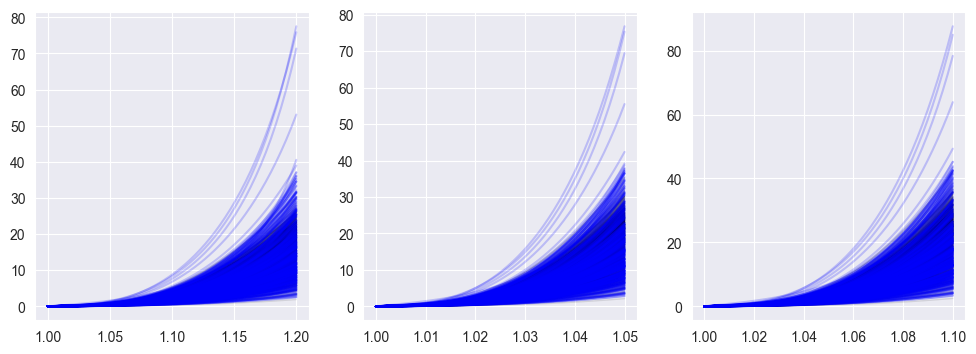

In [171]:
ids = np.random.choice(np.arange(w_diffusion_scaled.shape[0]), size=100)
w_diffusion_scaled_2 = w_diffusion_scaled[ids]

batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros((w_diffusion_scaled_2.shape[1])*batch_size).reshape((batch_size, w_diffusion_scaled_2.shape[1]))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model = ApproximateScore() # from diffusion_utils
params = score_model.init(rng, x, time) # from diffusion_utils
#Initialize the optimizer
optimizer = optax.adam(1.e-5)
opt_state = optimizer.init(params)
N_epochs = 500
train_size = w_diffusion.shape[0]
batch_size = 10
batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size

params = train_diffusion(w_diffusion_scaled_2, score_model, N_epochs, train_size, batch_size, steps_per_epoch, rng, params, optimizer, opt_state)


# Sample using the trained params
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, w_diffusion_scaled_2.shape[1], 1000, drift, dispersion, trained_score)


# Make stress predictions and compare
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
diff_stat_100 = []
tikzdata = [lam_vec[2*50:3*50,0]]
for l in samples:
    l_unscaled = l*std_x+mu_x 
    sample_params = unravel_params(l_unscaled)

    params_I1 = (params_I1c, sample_params[0])
    params_I2 = (params_I2c, sample_params[1])
    NODE_weights = (params_I1, params_I2)
    params = (NODE_weights, sample_params[2], sample_params[3])

    mymodel = NODE_model(params)
    sigx,sigy = eval_Cauchy_vmap(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel)

    axs[0].plot(lam_vec[:50,1],       sigx[:50],      color='k',linewidth=1,alpha=0.1)
    axs[1].plot(lam_vec[50:2*50,0],   sigx[50:2*50],  color='k',linewidth=1,alpha=0.1)
    axs[2].plot(lam_vec[2*50:3*50,0], sigx[2*50:3*50],color='k',linewidth=1,alpha=0.1)

    diff_stat_100.append(sigx[-1])
    tikzdata.append(sigx[2*50:3*50])

tikzdata = np.array(tikzdata)
np.savetxt('tikz/fig_analytical_wide_data/model_100_sgmx_equi.csv', tikzdata.T, header = header, comments = '')

for j in range(J):
    axs[0].plot(lam_vec[:50,1],       sigma_gt_s[j][0][:50],      color='b',alpha=0.2)
    axs[1].plot(lam_vec[50:2*50,0],   sigma_gt_s[j][0][50:2*50],  color='b',alpha=0.2)
    axs[2].plot(lam_vec[2*50:3*50,0], sigma_gt_s[j][0][2*50:3*50],color='b',alpha=0.2)

diff_stat_100 = np.array(diff_stat_100)
y_diff_100 = gaussian_kde(diff_stat_100)(x_dist)
np.savetxt('tikz/fig_analytical_wide_data/model_100_sgmx_at_1.1_equi.csv', np.stack([x_dist,y_diff_100]).T, header='x y', comments='')


[(0.0, 87.64731623019014), Text(0.5, 1.0, 'Diffusion')]

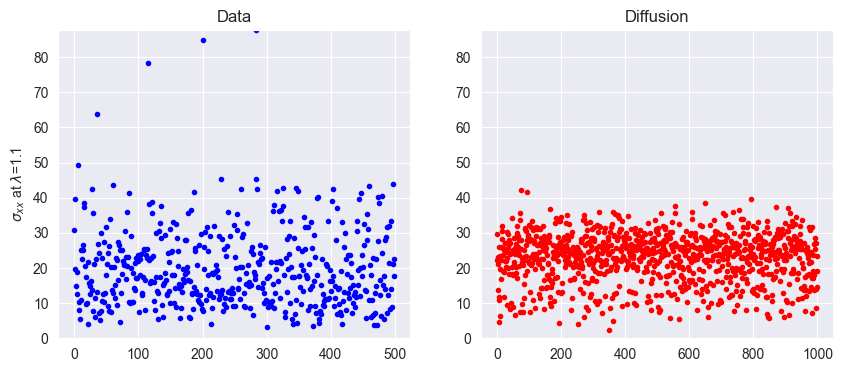

In [172]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(data_stat,'b.')
ax[1].plot(diff_stat_100, 'r.')

ax[0].set(ylim=[0,np.max(data_stat)], title='Data', ylabel='$\sigma_{xx}$ at $\lambda$=1.1')
ax[1].set(ylim=[0,np.max(data_stat)], title='Diffusion')

In [ ]:
ids = np.random.choice(np.arange(w_diffusion_scaled.shape[0]), size=50)
w_diffusion_scaled_2 = w_diffusion_scaled[ids]

batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros((w_diffusion_scaled_2.shape[1])*batch_size).reshape((batch_size, w_diffusion_scaled_2.shape[1]))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model = ApproximateScore() # from diffusion_utils
params = score_model.init(rng, x, time) # from diffusion_utils
#Initialize the optimizer
optimizer = optax.adam(1.e-5)
opt_state = optimizer.init(params)
N_epochs = 500
train_size = w_diffusion.shape[0]
batch_size = 10
batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size

params = train_diffusion(w_diffusion_scaled_2, score_model, N_epochs, train_size, batch_size, steps_per_epoch, rng, params, optimizer, opt_state)


# Sample using the trained params
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, w_diffusion_scaled_2.shape[1], 1000, drift, dispersion, trained_score)


# Make stress predictions and compare
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
diff_stat_50 = []
tikzdata = [lam_vec[2*50:3*50,0]]
for l in samples:
    l_unscaled = l*std_x+mu_x 
    sample_params = unravel_params(l_unscaled)

    params_I1 = (params_I1c, sample_params[0])
    params_I2 = (params_I2c, sample_params[1])
    NODE_weights = (params_I1, params_I2)
    params = (NODE_weights, sample_params[2], sample_params[3])

    mymodel = NODE_model(params)
    sigx,sigy = eval_Cauchy_vmap(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel)

    axs[0].plot(lam_vec[:50,1],       sigx[:50],      color='k',linewidth=1,alpha=0.1)
    axs[1].plot(lam_vec[50:2*50,0],   sigx[50:2*50],  color='k',linewidth=1,alpha=0.1)
    axs[2].plot(lam_vec[2*50:3*50,0], sigx[2*50:3*50],color='k',linewidth=1,alpha=0.1)

    diff_stat_50.append(sigx[-1])
    tikzdata.append(sigx[2*50:3*50])

tikzdata = np.array(tikzdata)
np.savetxt('tikz/fig_analytical_wide_data/model_50_sgmx_equi.csv', tikzdata.T, header = header, comments = '')

data_stat = []
for j in range(J):
    axs[0].plot(lam_vec[:50,1],       sigma_gt_s[j][0][:50],      color='b',alpha=0.2)
    axs[1].plot(lam_vec[50:2*50,0],   sigma_gt_s[j][0][50:2*50],  color='b',alpha=0.2)
    axs[2].plot(lam_vec[2*50:3*50,0], sigma_gt_s[j][0][2*50:3*50],color='b',alpha=0.2)
    data_stat.append(sigma_gt_s[j][0][-1])

diff_stat_50 = np.array(diff_stat_50)
y_diff_50 = gaussian_kde(diff_stat_50)(x_dist)
np.savetxt('tikz/fig_analytical_wide_data/model_50_sgmx_at_1.1_equi.csv', np.stack([x_dist,y_diff_50]).T, header='x y', comments='')


[(0.0, 87.64731623019014), Text(0.5, 1.0, 'Diffusion')]

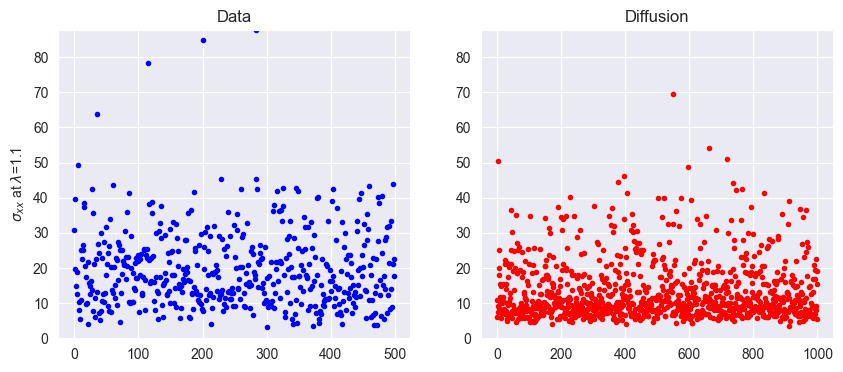

In [174]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(data_stat,'b.')
ax[1].plot(diff_stat_50, 'r.')

ax[0].set(ylim=[0,np.max(data_stat)], title='Data', ylabel='$\sigma_{xx}$ at $\lambda$=1.1')
ax[1].set(ylim=[0,np.max(data_stat)], title='Diffusion')

Epoch 0 	, Loss 1.015905 


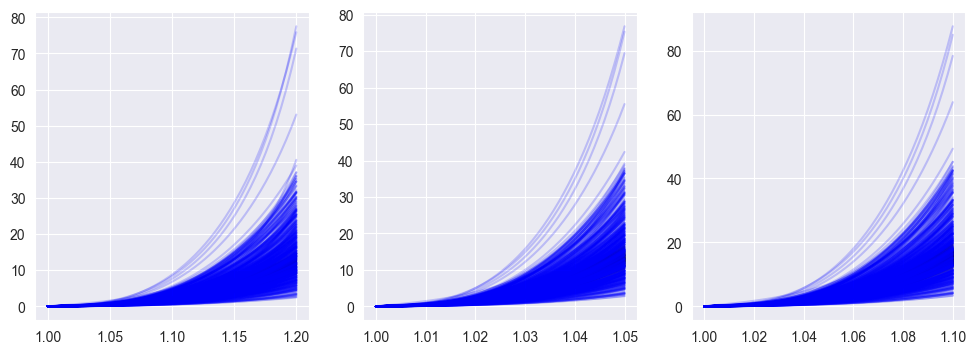

In [176]:
w_diffusion_scaled_2 = w_diffusion_scaled[:10]

batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros((w_diffusion_scaled_2.shape[1])*batch_size).reshape((batch_size, w_diffusion_scaled_2.shape[1]))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model = ApproximateScore() # from diffusion_utils
params = score_model.init(rng, x, time) # from diffusion_utils
#Initialize the optimizer
optimizer = optax.adam(1.e-5)
opt_state = optimizer.init(params)
N_epochs = 500
train_size = w_diffusion.shape[0]
batch_size = 10
batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size

params = train_diffusion(w_diffusion_scaled_2, score_model, N_epochs, train_size, batch_size, steps_per_epoch, rng, params, optimizer, opt_state)


# Sample using the trained params
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, w_diffusion_scaled_2.shape[1], 1000, drift, dispersion, trained_score)


# Make stress predictions and compare
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
diff_stat_10 = []
tikzdata = [lam_vec[2*50:3*50,0]]
for l in samples:
    l_unscaled = l*std_x+mu_x 
    sample_params = unravel_params(l_unscaled)

    params_I1 = (params_I1c, sample_params[0])
    params_I2 = (params_I2c, sample_params[1])
    NODE_weights = (params_I1, params_I2)
    params = (NODE_weights, sample_params[2], sample_params[3])

    mymodel = NODE_model(params)
    sigx,sigy = eval_Cauchy_vmap(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel)

    axs[0].plot(lam_vec[:50,1],       sigx[:50],      color='k',linewidth=1,alpha=0.1)
    axs[1].plot(lam_vec[50:2*50,0],   sigx[50:2*50],  color='k',linewidth=1,alpha=0.1)
    axs[2].plot(lam_vec[2*50:3*50,0], sigx[2*50:3*50],color='k',linewidth=1,alpha=0.1)

    diff_stat_10.append(sigx[-1])
    tikzdata.append(sigx[2*50:3*50])

tikzdata = np.array(tikzdata)
np.savetxt('tikz/fig_analytical_wide_data/model_10_sgmx_equi.csv', tikzdata.T, header = header, comments = '')

data_stat = []
for j in range(J):
    axs[0].plot(lam_vec[:50,1],       sigma_gt_s[j][0][:50],      color='b',alpha=0.2)
    axs[1].plot(lam_vec[50:2*50,0],   sigma_gt_s[j][0][50:2*50],  color='b',alpha=0.2)
    axs[2].plot(lam_vec[2*50:3*50,0], sigma_gt_s[j][0][2*50:3*50],color='b',alpha=0.2)
    data_stat.append(sigma_gt_s[j][0][-1])

# data_stat = np.array(data_stat)
# xmin = np.min(data_stat)
# xmax = np.max(data_stat)
# r = xmax-xmin
# x = np.linspace(xmin - 0.3*r, xmax + 0.3*r)
# y_gt = gaussian_kde(data_stat)(x)

diff_stat_10 = np.array(diff_stat_10)
y_diff_10 = gaussian_kde(diff_stat_10)(x_dist)
np.savetxt('tikz/fig_analytical_wide_data/model_10_sgmx_at_1.1_equi.csv', np.stack([x_dist,y_diff_10]).T, header='x y', comments='')


Epoch 0 	, Loss 1.015034 


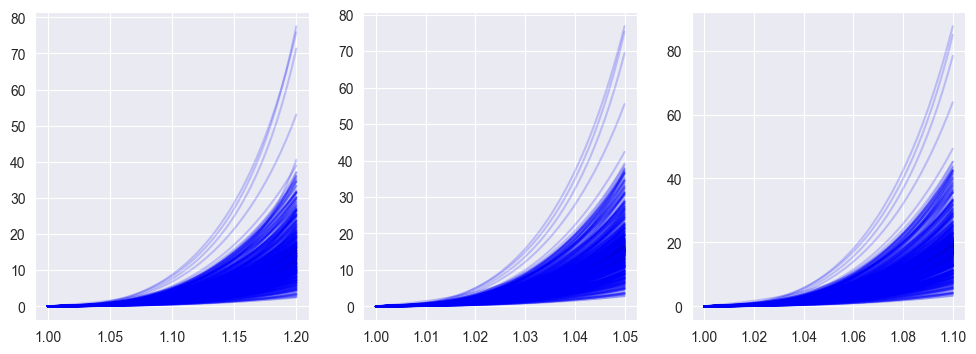

In [178]:
w_diffusion_scaled_2 = w_diffusion_scaled[:5]

batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros((w_diffusion_scaled_2.shape[1])*batch_size).reshape((batch_size, w_diffusion_scaled_2.shape[1]))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model = ApproximateScore() # from diffusion_utils
params = score_model.init(rng, x, time) # from diffusion_utils
#Initialize the optimizer
optimizer = optax.adam(1.e-5)
opt_state = optimizer.init(params)
N_epochs = 500
train_size = w_diffusion.shape[0]
batch_size = 10
batch_size = min(train_size, batch_size)
steps_per_epoch = train_size // batch_size

params = train_diffusion(w_diffusion_scaled_2, score_model, N_epochs, train_size, batch_size, steps_per_epoch, rng, params, optimizer, opt_state)


# Sample using the trained params
trained_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, w_diffusion_scaled_2.shape[1], 1000, drift, dispersion, trained_score)


# Make stress predictions and compare
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
diff_stat_5 = []
tikzdata = [lam_vec[2*50:3*50,0]]
for l in samples:
    l_unscaled = l*std_x+mu_x 
    sample_params = unravel_params(l_unscaled)

    params_I1 = (params_I1c, sample_params[0])
    params_I2 = (params_I2c, sample_params[1])
    NODE_weights = (params_I1, params_I2)
    params = (NODE_weights, sample_params[2], sample_params[3])

    mymodel = NODE_model(params)
    sigx,sigy = eval_Cauchy_vmap(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel)

    axs[0].plot(lam_vec[:50,1],       sigx[:50],      color='k',linewidth=1,alpha=0.1)
    axs[1].plot(lam_vec[50:2*50,0],   sigx[50:2*50],  color='k',linewidth=1,alpha=0.1)
    axs[2].plot(lam_vec[2*50:3*50,0], sigx[2*50:3*50],color='k',linewidth=1,alpha=0.1)

    diff_stat_5.append(sigx[-1])
    tikzdata.append(sigx[2*50:3*50])

tikzdata = np.array(tikzdata)
np.savetxt('tikz/fig_analytical_wide_data/model_5_sgmx_equi.csv', tikzdata.T, header = header, comments = '')

data_stat = []
for j in range(J):
    axs[0].plot(lam_vec[:50,1],       sigma_gt_s[j][0][:50],      color='b',alpha=0.2)
    axs[1].plot(lam_vec[50:2*50,0],   sigma_gt_s[j][0][50:2*50],  color='b',alpha=0.2)
    axs[2].plot(lam_vec[2*50:3*50,0], sigma_gt_s[j][0][2*50:3*50],color='b',alpha=0.2)
    data_stat.append(sigma_gt_s[j][0][-1])

diff_stat_5 = np.array(diff_stat_5)
y_diff_5 = gaussian_kde(diff_stat_5)(x_dist)
np.savetxt('tikz/fig_analytical_wide_data/model_5_sgmx_at_1.1_equi.csv', np.stack([x_dist,y_diff_5]).T, header='x y', comments='')


In [52]:
import matplotlib.pylab as pl

In [194]:
aux = np.loadtxt('tikz/fig_analytical_wide_data/model_5_sgmx_at_1.1_equi.csv', skiprows=1)
x_dist, y_diff_5 = aux.T
aux = np.loadtxt('tikz/fig_analytical_wide_data/model_10_sgmx_at_1.1_equi.csv', skiprows=1)
x_dist, y_diff_10 = aux.T
aux = np.loadtxt('tikz/fig_analytical_wide_data/model_50_sgmx_at_1.1_equi.csv', skiprows=1)
x_dist, y_diff_50 = aux.T
aux = np.loadtxt('tikz/fig_analytical_wide_data/model_100_sgmx_at_1.1_equi.csv', skiprows=1)
x_dist, y_diff_100 = aux.T
aux = np.loadtxt('tikz/fig_analytical_wide_data/model_500_sgmx_at_1.1_equi.csv', skiprows=1)
x_dist, y_diff_500 = aux.T

[(-0.001, 0.1)]

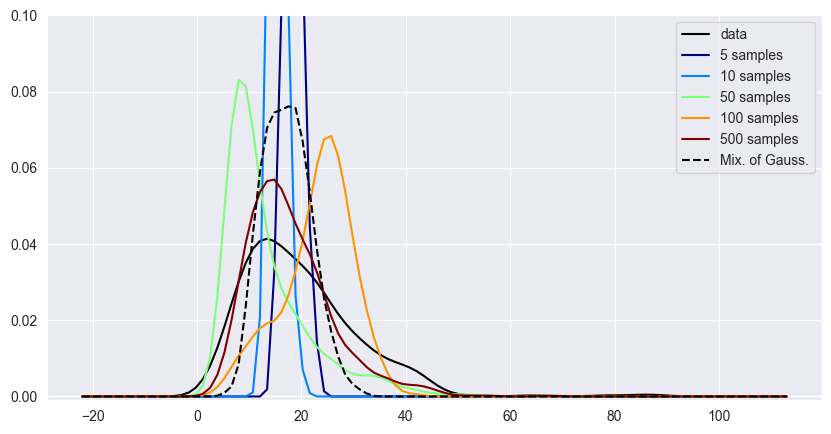

In [195]:
fig, ax = plt.subplots(figsize=(10,5))
c = pl.cm.jet(np.linspace(0,1,5))

ax.plot(x_dist, y_gt,       'k-',       label='data')
ax.plot(x_dist, y_diff_5,   color=c[0], label='5 samples')
ax.plot(x_dist, y_diff_10,  color=c[1], label='10 samples')
ax.plot(x_dist, y_diff_50,  color=c[2], label='50 samples')
ax.plot(x_dist, y_diff_100, color=c[3], label='100 samples')
ax.plot(x_dist, y_diff_500, color=c[4], label='500 samples')
ax.plot(x_dist, y_GM,       'k--',      label='Mix. of Gauss.')
ax.legend()

ax.set(ylim=[-0.001,0.1])